### ADNI-trained encoder for DFI method.

In this notebook, an alternative encoder for DFI method on ADNI dataset is constructed.

The encoder is a VGG-16 neural network, trained over age (or age & DX) on a separate training subset of ADNI.

In [95]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.models import vgg16, resnet50
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
import torch.nn.functional as F
import torchvision.transforms as transforms

import os

from skimage import img_as_float
from skimage.transform import resize
from skimage.io import imread
from sklearn.model_selection import train_test_split

from tqdm import tqdm, tqdm_notebook

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
def to_gpu(obj):
    if torch.cuda.is_available():
        return obj.cuda()
    return obj

def to_cpu(obj):
    if torch.cuda.is_available():
        return obj.cpu()
    return obj

def image_to_tensor(image):
    #return np.float32(np.array(image) / 255.0)[np.newaxis, :, :, :]
    return to_gpu(torch.FloatTensor(np.rollaxis(np.float32(np.array(image) / 255.0), 2, 0)))

def channel_first(ar):
    # ar can be an image (H, W, C) or an array of images (N, H, W, C)
    if isinstance(ar, np.ndarray):
        if len(ar.shape) == 3:
            return np.rollaxis(ar, 2, 0)
        elif len(ar.shape) == 4:
            return np.rollaxis(ar, 3, 1)
    else:    # assuming torch types
        if len(ar.shape) == 3:
            return ar.permute(2, 0, 1)
        elif len(ar.shape) == 4:
            return ar.permute(0, 3, 1, 2)

def channel_last(ar):
    # ar can be an image (C, H, W) or an array of images (N, C, H, W)
    if isinstance(ar, np.ndarray):
        if len(ar.shape) == 3:
            return np.rollaxis(ar, 0, 3)
        elif len(ar.shape) == 4:
            return np.rollaxis(ar, 1, 4)
    else:    # assuming torch types
        if len(ar.shape) == 3:
            return ar.permute(1, 2, 0)
        elif len(ar.shape) == 4:
            return ar.permute(0, 2, 3, 1)

def normalize(ar, eps=1e-15):
    return (ar - ar.min()) / (ar.max() - ar.min() + eps) 

### Loading data

In [98]:
batch_size = 6

input_size = 128

In [99]:
class mri_data(Dataset):
    def __init__(self, 
                 folder='../../data/bids_slices', 
                 metadata='../../data/matched_saved_exp.csv', 
                 columns=['anat_ras', 'AGEreal', 'DX', 'ADAS13', 'FAQ'],
                 resize_shape = (128,128),
                 DX_dict = {'CN':0,m'MCI':1,'Dementia':2},
                 transform=None):
        
        self.meta = pd.read_csv(metadata)[['id']+columns]
        self.folder = folder
        self.resize_shape = resize_shape
        self.DX_dict = DX_dict
        self.transform = transform
        
    def __len__(self):
        return len(self.meta)
    
    def __getitem__(self, idx):
        true_path = self.folder + '/' + self.meta.anat_ras[idx][54:-7] + '.png'
        img = imread(fname=true_path)

        attr = self.meta.iloc[idx].drop(['anat_ras', 'id'])
        attr['DX'] = self.DX_dict[attr['DX']]

        if not self.resize_shape is None:
            img = resize(img, output_shape=self.resize_shape, mode='reflect', preserve_range=True)

        img = img_as_float(img) / 255.0

        if self.transform is not None:
            img = self.transform(img)

        return {'input': img, 'attr': np.array(attr, dtype=np.float32)}

In [100]:
#tran = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
data = mri_data(transform=transforms.Compose([transforms.ToTensor(), 
                                              transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])]),
                resize_shape=(input_size, input_size))

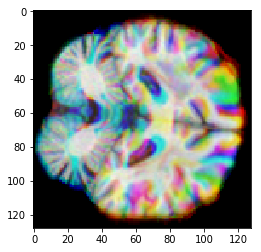

In [101]:
plt.imshow(to_cpu(normalize(channel_last(data[50]['input']))).data.numpy())

#### Generating train and validation indices

This is done in a stratified by ages fashion (it's harder to stratify by 2 factors).

In [ ]:
ages = np.array([data[i]['attr'][0] for i in tqdm(range(len(data)))])
dx = np.array([data[i]['attr'][1] for i in tqdm(range(len(data)))])

  2%|▏         | 123/4968 [00:20<13:07,  6.15it/s]

Text(0.5,1,'Dx')

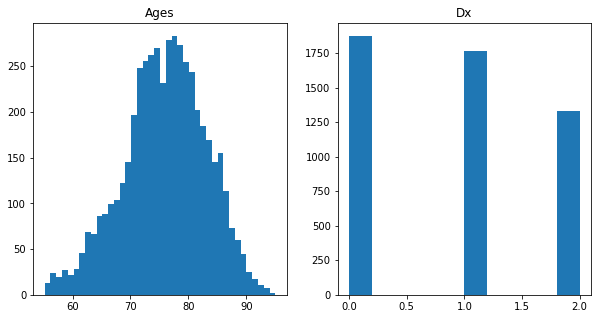

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(ages, bins=40)
ax[0].set_title('Ages')
ax[1].hist(dx)
ax[1].set_title('Dx')

In [72]:
np.linspace(np.percentile(ages, 10), np.percentile(ages, 90), num=4)

array([66.27000122, 72.54666697, 78.82333272, 85.09999847])

(array([330., 235., 286., 488., 651., 687., 688., 577., 434., 592.]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <a list of 10 Patch objects>)

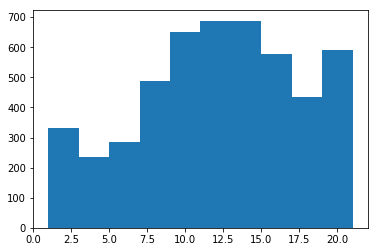

In [11]:
ages_group_inds = np.concatenate([[-np.inf], np.linspace(np.percentile(ages, 5), np.percentile(ages, 95), num=20), [np.inf]])
ages_discrete = np.digitize(ages, ages_group_inds)
plt.hist(ages_discrete)

In [20]:
_, _, train_idx, all_valid_idx = train_test_split(np.arange(len(data))[:, np.newaxis], np.arange(len(data)), 
                 train_size=0.5, test_size=0.5, random_state=123, stratify=ages_discrete)
train_idx = train_idx.astype(int)
all_valid_idx = all_valid_idx.astype(int)
valid_idx = np.random.choice(all_valid_idx, int(len(all_valid_idx) * 0.3), replace=False)
print(len(train_idx), len(all_valid_idx), len(set(train_idx) & set(all_valid_idx)))
print(len(train_idx), len(valid_idx))

2484 2484 0
2484 745


Text(0.5,1,'Dx (train)')

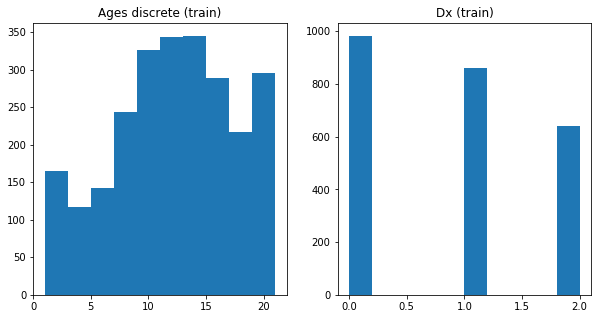

In [21]:
ages_train = np.array([data[i]['attr'][0] for i in train_idx])
dx_train = np.array([data[i]['attr'][1] for i in train_idx])
ages_train_discrete = np.digitize(ages_train, ages_group_inds)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(ages_train_discrete)
ax[0].set_title('Ages discrete (train)')
ax[1].hist(dx_train)
ax[1].set_title('Dx (train)')

Text(0.5,1,'Dx (valid)')

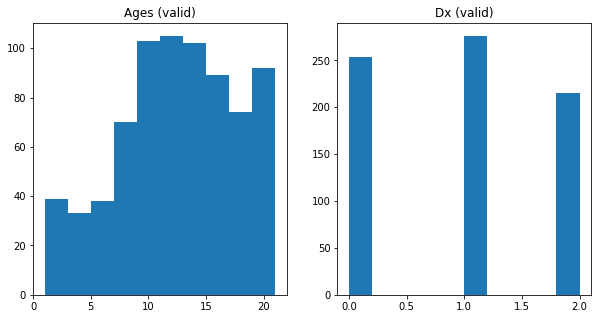

In [22]:
ages_valid = np.array([data[i]['attr'][0] for i in valid_idx])
dx_valid = np.array([data[i]['attr'][1] for i in valid_idx])
ages_discrete_valid = np.digitize(ages_valid, ages_group_inds)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(ages_discrete_valid)
ax[0].set_title('Ages (valid)')
ax[1].hist(dx_valid)
ax[1].set_title('Dx (valid)')

In [23]:
#np.save('../models/DFI_enc_train_idx.npy', train_idx)
#np.save('../models/DFI_enc_valid_idx.npy', valid_idx)
#np.save('../models/DFI_enc_all_valid_idx.npy', all_valid_idx)

train_idx = np.load('../models/DFI_enc_train_idx.npy')
valid_idx = np.load('../models/DFI_enc_valid_idx.npy')
all_valid_idx = np.load('../models/DFI_enc_all_valid_idx.npy')

#### Data loaders

In [25]:
class SubsetSeqSampler(Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (el for el in self.indices)

    def __len__(self):
        return len(self.indices)

In [26]:
train_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, 
                                           sampler=SubsetRandomSampler(train_idx), num_workers=8)
valid_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, 
                                           sampler=SubsetSeqSampler(valid_idx), num_workers=8)

### Building a network model

We are going to use a VGG-16 network that will be trained to predict age (*AGEreal*) and diagnosis (*DX*, *ADAS13*, *FAQ* &mdash; not sure which one is better).

VGG-16 is used due to expressiveness of its features, as recommended for DFI method. High quality is not essential here.

BatchNorms will likely be not used, since they affect the features expressiveness (checked for CelebA).

In [28]:
class Reshape(nn.Module):
    """Reshapes the output tensor. 
    *args represents the resulting shape wanted (without batch size as a first axis)."""
    
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view((x.size()[0],) + self.shape)

In [89]:
model = nn.Sequential(# feature extractor (copied from torchvision.models.vgg16 summary)
                      nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      #nn.BatchNorm2d(64),
                      nn.ReLU(),
                      nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      #nn.BatchNorm2d(64),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    
                      nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      #nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      #nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    
                      nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      #nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      #nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      #nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    
                      nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      #nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      #nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      #nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    
                      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      #nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      #nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      #nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    
                      Reshape(512 * (input_size // 32) ** 2),    # flatten
                      # classifier
                      nn.Linear(in_features=512 * (input_size // 32) ** 2, out_features=4096, bias=True),
                      nn.ReLU(),
                      nn.Dropout(p=0.5),
                      nn.Linear(in_features=4096, out_features=4096, bias=True),
                      nn.ReLU(),
                      nn.Dropout(p=0.5),
                      nn.Linear(in_features=4096, out_features=4, bias=True)
                     )
model = to_gpu(model)
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): Conv2d(512, 512, ke

In [90]:
# Combined age+dx loss (crossentropy over dx, mse over age)
class _full_loss(torch.nn.Module):
    def __init__(self, alpha_age=1, alpha_dx=1):
        super(_full_loss, self).__init__()
        self.alpha_age = alpha_age
        self.alpha_dx = alpha_dx
    
    def forward(self, pred, true):
        pred_age, pred_dx = pred[:, 0:1], pred[:, 1:]
        true_age, true_dx = true[:, 0:1], true[:, 1]
        age_loss = F.mse_loss(pred_age, true_age)
        pred_dx = F.log_softmax(pred_dx, dim=1)
        dx_loss = F.nll_loss(pred_dx, true_dx.long())
        ans = self.alpha_age * age_loss + self.alpha_dx * dx_loss
        return ans

In [91]:
# mse over age
class _age_loss(torch.nn.Module):
    def __init__(self):
        super(_age_loss, self).__init__()
    
    def forward(self, pred, true):
        pred_age, pred_dx = pred[:, 0:1], pred[:, 1:]
        true_age, true_dx = true[:, 0:1], true[:, 1]
        age_loss = F.mse_loss(pred_age, true_age)
        
        ans = age_loss
        return ans

In [92]:
#loss = to_gpu(_full_loss(alpha_age=1, alpha_dx=1))
loss = to_gpu(_age_loss())
opt = torch.optim.Adam(model.parameters(), lr=3e-6)

### Training

In [93]:
n_epochs = 200

In [94]:
best_av_val_loss = np.inf
for epoch in range(n_epochs):
    # training
    model.train()
    av_train_loss = 0
    for i, batch in enumerate(train_loader):
        model.zero_grad()
        cur_input, cur_attr = batch['input'], batch['attr']
        cur_batch_size = cur_input.size(0)
        
        cur_input = to_gpu(cur_input.float())
        cur_output = to_gpu(cur_attr[:, :2].float())
        
        pred_output = model(cur_input)
        err = loss(pred_output, cur_output)
        err.backward()
        
        opt.step()
        av_train_loss += err.data[0]
        
        print('[{}/{}][{}/{}] Loss: {:.4}'.format(epoch, n_epochs, i, len(train_loader), 
                                                   err.data[0]), end='')
        print('\r', end='')
    
    av_train_loss /= len(train_loader)
    print('\n[{}/{}] Train loss: {:.4}'.format(epoch, n_epochs, av_train_loss))
    
    # validation
    model.eval()
    av_val_loss = 0
    for i, batch in enumerate(valid_loader):
        cur_input, cur_attr = batch['input'], batch['attr']
        cur_batch_size = cur_input.size(0)
        
        cur_input = to_gpu(cur_input.float())
        cur_output = to_gpu(cur_attr[:, :2].float())

        pred_output = model(cur_input)
        err = loss(pred_output, cur_output)
        av_val_loss += err.data[0]
        
    av_val_loss /= len(valid_loader)
    print('[{}/{}] Val_loss: {:.4}'.format(epoch, n_epochs, av_val_loss))
    
    if av_val_loss < best_av_val_loss:
        best_av_val_loss = av_val_loss
        torch.save(model, '../models/DFI_enc_for_age_best_vgg_model_no_bn.pth')

/home/seva100/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/seva100/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[0/200][413/414] Loss: 101.4e+03
[0/200] Train loss: 1.89e+03


/home/seva100/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[0/200] Val_loss: 46.2


/home/seva100/miniconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1/200][413/414] Loss: 104.3
[1/200] Train loss: 58.48
[1/200] Val_loss: 43.55
[2/200][413/414] Loss: 10.28
[2/200] Train loss: 59.24
[2/200] Val_loss: 57.95
[3/200][413/414] Loss: 69.15
[3/200] Train loss: 58.37
[3/200] Val_loss: 48.38
[4/200][413/414] Loss: 111.7
[4/200] Train loss: 57.14
[4/200] Val_loss: 44.02
[5/200][413/414] Loss: 40.28
[5/200] Train loss: 57.54
[5/200] Val_loss: 44.43
[6/200][413/414] Loss: 76.02
[6/200] Train loss: 57.67
[6/200] Val_loss: 42.0
[7/200][413/414] Loss: 24.35
[7/200] Train loss: 57.07
[7/200] Val_loss: 42.81
[8/200][413/414] Loss: 82.42
[8/200] Train loss: 58.14
[8/200] Val_loss: 42.26
[9/200][413/414] Loss: 29.87
[9/200] Train loss: 53.84
[9/200] Val_loss: 43.53
[10/200][413/414] Loss: 56.48
[10/200] Train loss: 56.41
[10/200] Val_loss: 41.7
[11/200][413/414] Loss: 49.81
[11/200] Train loss: 58.44
[11/200] Val_loss: 41.46
[12/200][413/414] Loss: 36.15
[12/200] Train loss: 56.43
[12/200] Val_loss: 56.27
[13/200][413/414] Loss: 37.82
[13/200] Train 

[101/200] Val_loss: 61.16
[102/200][413/414] Loss: 53.13
[102/200] Train loss: 49.48
[102/200] Val_loss: 44.34
[103/200][413/414] Loss: 124.9
[103/200] Train loss: 50.49
[103/200] Val_loss: 38.78
[104/200][413/414] Loss: 19.01
[104/200] Train loss: 48.48
[104/200] Val_loss: 40.1
[105/200][413/414] Loss: 28.62
[105/200] Train loss: 49.31
[105/200] Val_loss: 42.62
[106/200][413/414] Loss: 34.96
[106/200] Train loss: 49.55
[106/200] Val_loss: 38.32
[107/200][413/414] Loss: 39.27
[107/200] Train loss: 48.81
[107/200] Val_loss: 38.88
[108/200][413/414] Loss: 89.29
[108/200] Train loss: 50.31
[108/200] Val_loss: 41.06
[109/200][413/414] Loss: 58.84
[109/200] Train loss: 48.82
[109/200] Val_loss: 37.72
[110/200][413/414] Loss: 77.27
[110/200] Train loss: 50.39
[110/200] Val_loss: 42.52
[111/200][413/414] Loss: 29.752
[111/200] Train loss: 49.64
[111/200] Val_loss: 38.24
[112/200][413/414] Loss: 74.63
[112/200] Train loss: 50.66
[112/200] Val_loss: 38.28
[113/200][413/414] Loss: 34.47
[113/200

### Evaluation and results analysis

In [81]:
model_loaded = torch.load('../models/DFI_enc_best_vgg_model_no_bn.pth')

In [82]:
model_loaded.eval()
val_true = []
val_pred = []
val_err = []
for i, batch in enumerate(valid_loader):
    cur_input, cur_attr = batch['input'], batch['attr']
    cur_batch_size = cur_input.size(0)

    cur_input = to_gpu(cur_input.float())
    cur_output = to_gpu(cur_attr[:, :2].float())
    val_true.append(cur_output.data)

    pred_output = model_loaded(cur_input)
    err = loss(pred_output, cur_output)
    
    pred_output[:, 1:] = F.softmax(pred_output[:, 1:], dim=1)
    val_pred.append(pred_output.data)
    val_err.append(to_cpu(err).data.numpy())

In [83]:
val_true = torch.cat(val_true, 0)
val_pred = torch.cat(val_pred, 0)
val_err = np.hstack(val_err)
val_true.shape, val_pred.shape, val_err.shape

(torch.Size([745, 2]), torch.Size([745, 4]), (125,))

In [84]:
print('mean val loss:', val_err.mean())

mean val loss: 24.145107


In [85]:
val_true

tensor([[ 85.3000,   1.0000],
        [ 84.3000,   0.0000],
        [ 77.1000,   2.0000],
        ...,
        [ 77.0000,   0.0000],
        [ 79.2000,   0.0000],
        [ 76.8000,   0.0000]], device='cuda:0')

In [86]:
val_pred

tensor([[ 82.0675,   0.4203,   0.2219,   0.3577],
        [ 79.1977,   0.4169,   0.2260,   0.3572],
        [ 77.2136,   0.4137,   0.2296,   0.3567],
        ...,
        [ 73.8812,   0.4098,   0.2342,   0.3560],
        [ 74.0290,   0.4099,   0.2341,   0.3559],
        [ 72.4002,   0.4078,   0.2366,   0.3556]], device='cuda:0')

In [87]:
val_pred_age = val_pred[:, 0]
val_pred_dx_argmax = torch.argmax(val_pred[:, 1:], dim=1)
print('age rmse:', torch.sqrt(torch.mean(torch.pow(val_pred_age - val_true[:, 0], 2))))
print('dx acc:', torch.sum(val_pred_dx_argmax == val_true[:, 1].long()).float() / len(val_pred_dx_argmax))

age rmse: tensor(4.9170, device='cuda:0')
dx acc: tensor(0.3409, device='cuda:0')


In [88]:
print('age, constant algo rmse:', 
      torch.sqrt(torch.mean(torch.pow(torch.mean(val_true[:, 0]) - val_true[:, 0], 2))))
print('dx acc:', 
      torch.sum(torch.mean(val_true[:, 1]).long() == val_true[:, 1].long()).float() / len(val_pred_dx_argmax))

age, constant algo rmse: tensor(6.9017, device='cuda:0')
dx acc: tensor(0.3409, device='cuda:0')
